In [1]:
import pandas as pd
import numpy as np

# misc
import gc
import time
import warnings

# stats
# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

# viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib_venn as venn

# nlp
import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# feature engineer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf

# settings
# start
color = sns.color_palette()
sns.set_style('dark')
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer() # 词性还原
tokenizer = TweetTokenizer() # 分词

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
import scipy as sp
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Using TensorFlow backend.


## Data Understanding

In [5]:
ROOT = 'data/'

In [6]:
train = pd.read_csv(ROOT + 'train.csv')
test = pd.read_csv(ROOT + 'test.csv')
sub = pd.read_csv(ROOT + 'sample_submission.csv')

In [8]:
train.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [9]:
test.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com


In [11]:
sub.head(2)

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448


In [13]:
train_len, test_len, sub_len = len(train.index), len(test.index), len(sub.index)
print(f'train size: {train_len}, test size: {test_len}, sample size: {sub_len}')

train size: 6079, test size: 476, sample size: 476


In [17]:
# count of missing values
miss_val_train = train.isnull().sum(axis=0) / train_len
miss_val_train = miss_val_train[miss_val_train > 0] * 100
miss_val_train

Series([], dtype: float64)

In [18]:
# number of train columns
len(list(train.columns))

41

In [20]:
# Check scoring for question
all_train_columns = list(train.columns)
question_answer_cols = all_train_columns[:11]
question_target_cols = all_train_columns[11:32]
answer_target_cols = all_train_columns[32:41]
print(f'question answer cols:{question_answer_cols}, \n question target cols:{question_target_cols}, \n answer_target_cols:{answer_target_cols}')

question answer cols:['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host'], 
 question target cols:['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written'], 
 answer_target_cols:['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answe

In [23]:
# check one question an answer
questiont = train['question_title'][0]
questionb = train['question_body'][0]
answer1 = train['answer'][0]
print(f'Question Topic: {questiont}, \n Question Details: {questionb}, \n Answer: {answer1}')

Question Topic: What am I losing when using extension tubes instead of a macro lens?, 
 Question Details: After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.

So, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens. An alternative is the electrical extension tubes.

Except for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2.8) instead of a macro lens?
, 
 Answer: I just got extension tubes, so here's the skin

In [24]:
train[question_answer_cols].loc[0]

qa_id                                                                 0
question_title        What am I losing when using extension tubes in...
question_body         After playing around with macro photography on...
question_user_name                                                 ysap
question_user_page           https://photo.stackexchange.com/users/1024
answer                I just got extension tubes, so here's the skin...
answer_user_name                                                 rfusca
answer_user_page             https://photo.stackexchange.com/users/1917
url                   http://photo.stackexchange.com/questions/9169/...
category                                                      LIFE_ARTS
host                                            photo.stackexchange.com
Name: 0, dtype: object

In [25]:
train[question_target_cols].loc[0]

question_asker_intent_understanding      1.000000
question_body_critical                   0.333333
question_conversational                  0.000000
question_expect_short_answer             0.000000
question_fact_seeking                    0.000000
question_has_commonly_accepted_answer    0.000000
question_interestingness_others          1.000000
question_interestingness_self            1.000000
question_multi_intent                    0.000000
question_not_really_a_question           0.000000
question_opinion_seeking                 1.000000
question_type_choice                     0.000000
question_type_compare                    0.000000
question_type_consequence                0.000000
question_type_definition                 0.000000
question_type_entity                     0.000000
question_type_instructions               1.000000
question_type_procedure                  0.000000
question_type_reason_explanation         0.000000
question_type_spelling                   0.000000


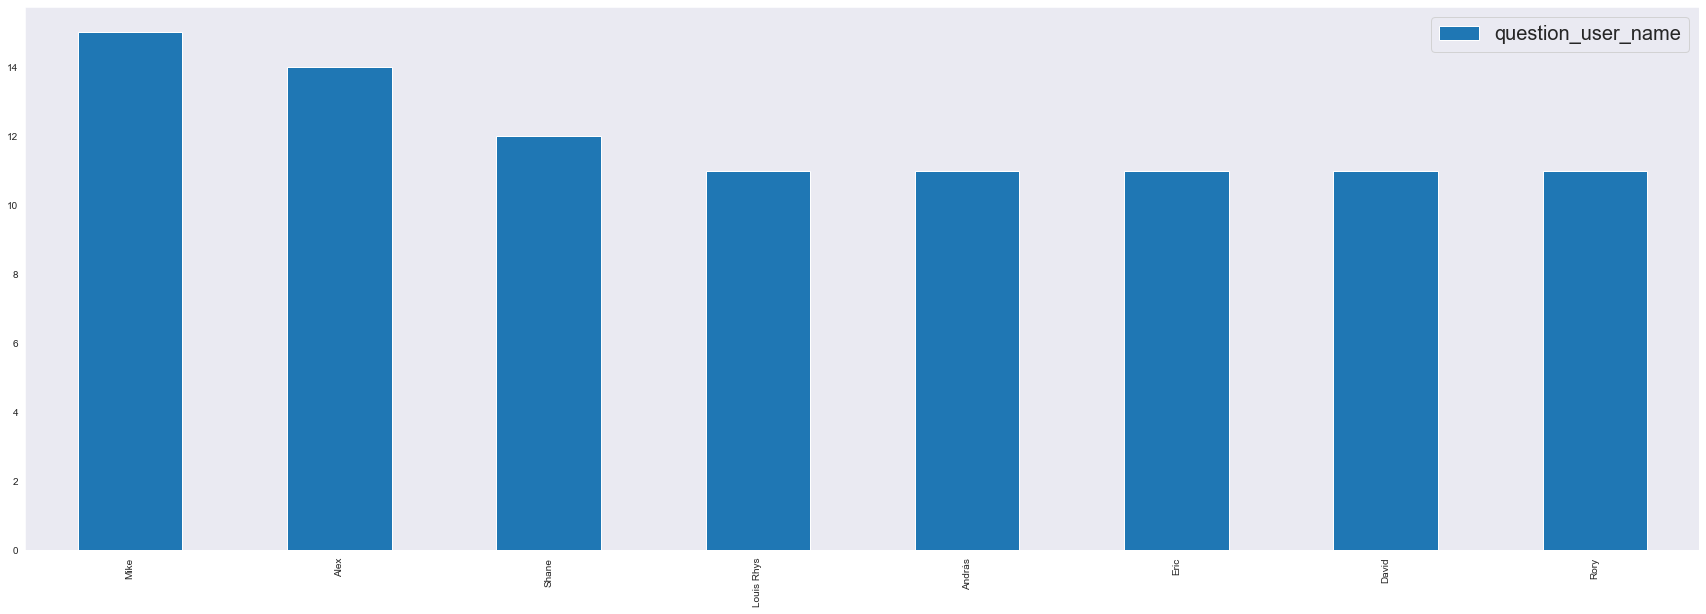

In [26]:
user_q_grp = train.question_user_name.value_counts()
user_q_grp.loc[user_q_grp > 10].plot(kind='bar', figsize=(30, 10), fontsize=10).legend(prop={'size':20})

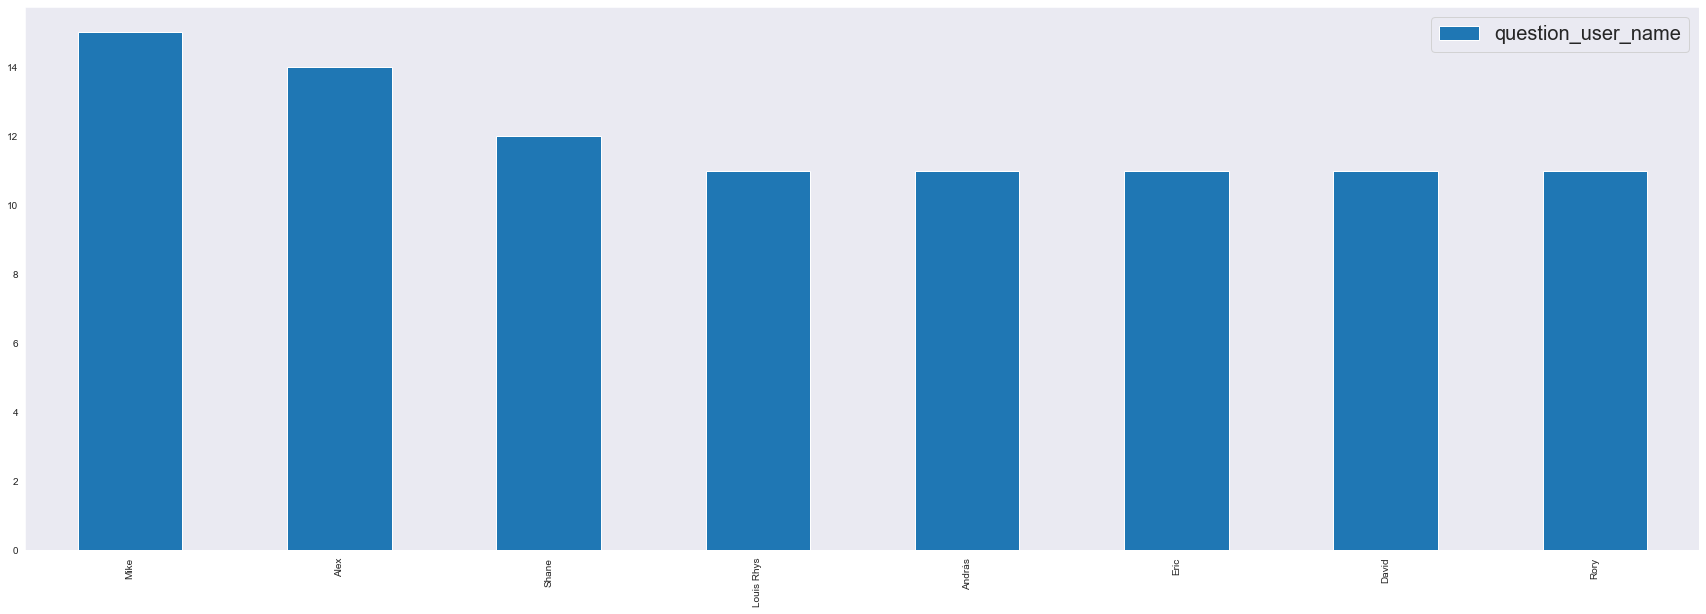

In [27]:
user_a_grp = train.question_user_name.value_counts()
user_a_grp.loc[user_a_grp > 10].plot(kind='bar', figsize=(30,10), fontsize=10).legend(prop={'size':20})

In [28]:
user_a_grp

Mike               15
Alex               14
Shane              12
Louis Rhys         11
András             11
                   ..
Anthony X           1
user3365207         1
TheCarver           1
Tianxiang Xiong     1
FiddleMeRagged      1
Name: question_user_name, Length: 3215, dtype: int64

In [29]:
user_q_grp

Mike               15
Alex               14
Shane              12
Louis Rhys         11
András             11
                   ..
Anthony X           1
user3365207         1
TheCarver           1
Tianxiang Xiong     1
FiddleMeRagged      1
Name: question_user_name, Length: 3215, dtype: int64

In [32]:
print(f'First Question Asked by Mike:{train.loc[train.question_user_name == "Mike"]["question_body"].values[1]}')

First Question Asked by Mike:I am currently creating a stored procedure that populates a table with a list of insert statements so that my DBAs can export the contents of the table to a text file and then paste the statements into SSMS and run (it is to copy data from test environment to live enviroment - I am constricted by the fact the 2 environments cannot see each other, bcp is not configured on the environment

My question is that the table I am going to export could have up to 2,000,000 insert statements. Is there a limit to what can be pasted in and run?



In [33]:
print(f'First Question Asked by Mike:{train.loc[train.question_user_name == "Mike"]["question_body"].values[0]}')

First Question Asked by Mike:Here are some common definitions from a dictionary for ‘literal’:


Being in accordance with, conforming to, or upholding the exact or primary meaning of a word or words.
Word for word; verbatim: a literal translation.
Avoiding exaggeration, metaphor, or embellishment; factual; prosaic: a literal description; a literal mind.


So what does it mean then to ‘take the Bible literally?’ Which definition are we referring to when we say ‘I take the Bible literally?’



In [34]:
train.loc[train.question_user_name == 'Mike']['question_user_page'].values

array(['https://christianity.stackexchange.com/users/1743',
       'https://dba.stackexchange.com/users/32050',
       'https://money.stackexchange.com/users/6945',
       'https://dba.stackexchange.com/users/34922',
       'https://superuser.com/users/79906',
       'https://christianity.stackexchange.com/users/1743',
       'https://stackoverflow.com/users/1397089',
       'https://stackoverflow.com/users/227675',
       'https://superuser.com/users/79906',
       'https://christianity.stackexchange.com/users/1743',
       'https://programmers.stackexchange.com/users/38644',
       'https://programmers.stackexchange.com/users/38644',
       'https://programmers.stackexchange.com/users/38644',
       'https://christianity.stackexchange.com/users/1743',
       'https://dba.stackexchange.com/users/34922'], dtype=object)

In [35]:
train[question_target_cols]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,1.000000,0.333333,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000
1,1.000000,1.000000,0.000000,0.500000,1.000000,1.0,0.444444,0.444444,0.666667,0.0,...,0.666667,0.666667,0.0,0.333333,0.0,0.000000,0.000000,0.333333,0.0,0.888889
2,0.888889,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.444444,0.333333,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.333333,0.333333,0.0,0.777778
3,0.888889,0.666667,0.666667,1.000000,1.000000,1.0,0.444444,0.444444,0.000000,0.0,...,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.888889
4,1.000000,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.666667,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,1.000000,0.777778,0.000000,1.000000,1.000000,1.0,0.888889,0.888889,0.333333,0.0,...,0.333333,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.0,0.777778
6075,1.000000,0.777778,0.000000,1.000000,0.666667,0.5,0.777778,0.777778,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.666667,0.666667,0.000000,0.0,0.777778
6076,0.888889,0.555556,0.000000,0.666667,0.333333,1.0,0.444444,0.333333,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.444444
6077,1.000000,0.444444,0.333333,0.000000,0.000000,0.0,0.777778,0.555556,1.000000,0.0,...,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.666667,0.0,1.000000


<function matplotlib.pyplot.show(*args, **kw)>

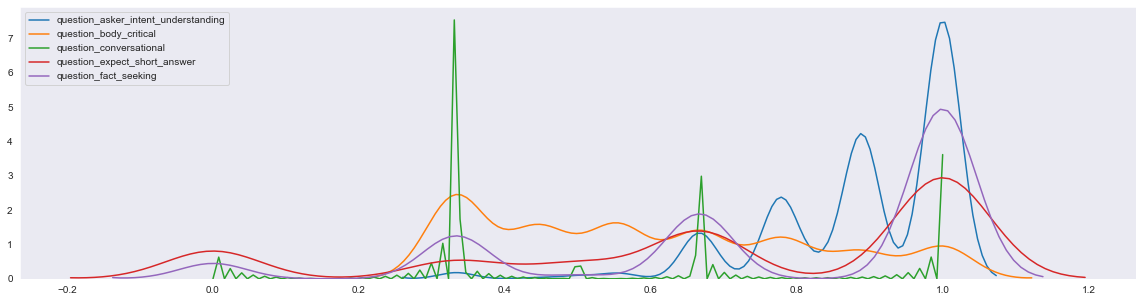

In [36]:
plt.figure(figsize=(20,5))
sns.distplot(train[question_target_cols[0]], hist=False, rug=False, kde=True, label=question_target_cols[0], axlabel=False)
sns.distplot(train[question_target_cols[1]], hist=False, rug=False, kde=True, label=question_target_cols[1], axlabel=False)
sns.distplot(train[question_target_cols[2]], hist=False, rug=False, kde=True, label=question_target_cols[2], axlabel=False)
sns.distplot(train[question_target_cols[3]], hist=False, rug=False, kde=True, label=question_target_cols[3], axlabel=False)
sns.distplot(train[question_target_cols[4]], hist=False, rug=False, kde=True, label=question_target_cols[4], axlabel=False)
plt.show

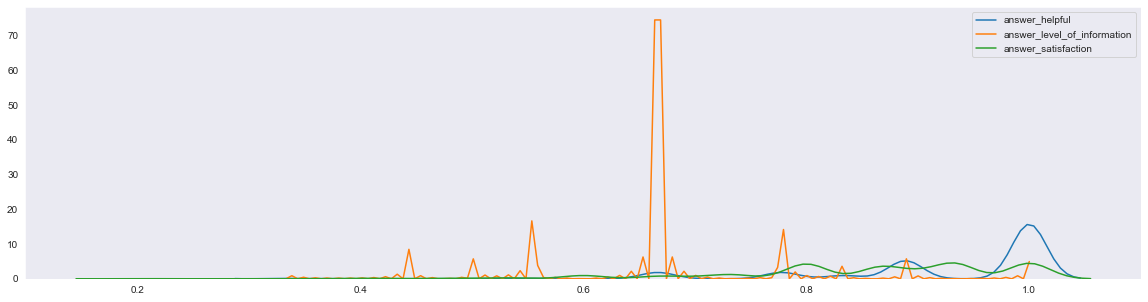

In [37]:
## lets see some distributions of answer targets
plt.figure(figsize=(20, 5))

sns.distplot(train[answer_target_cols[0]], hist= False , rug= False ,kde=True, label =answer_target_cols[0],axlabel =False )
sns.distplot(train[answer_target_cols[1]], hist= False , rug= False,label =answer_target_cols[1],axlabel =False)
#sns.distplot(train[answer_target_cols[2]], hist= False , rug= False,label =answer_target_cols[2],axlabel =False)
#sns.distplot(train[answer_target_cols[3]], hist= False , rug= False,label =answer_target_cols[3],axlabel =False)
sns.distplot(train[answer_target_cols[4]], hist= False , rug= False,label =answer_target_cols[4],axlabel =False)
plt.show()

In [38]:
train['category'].value_counts()

TECHNOLOGY       2441
STACKOVERFLOW    1253
CULTURE           963
SCIENCE           713
LIFE_ARTS         709
Name: category, dtype: int64

In [39]:
len(question_target_cols)

21

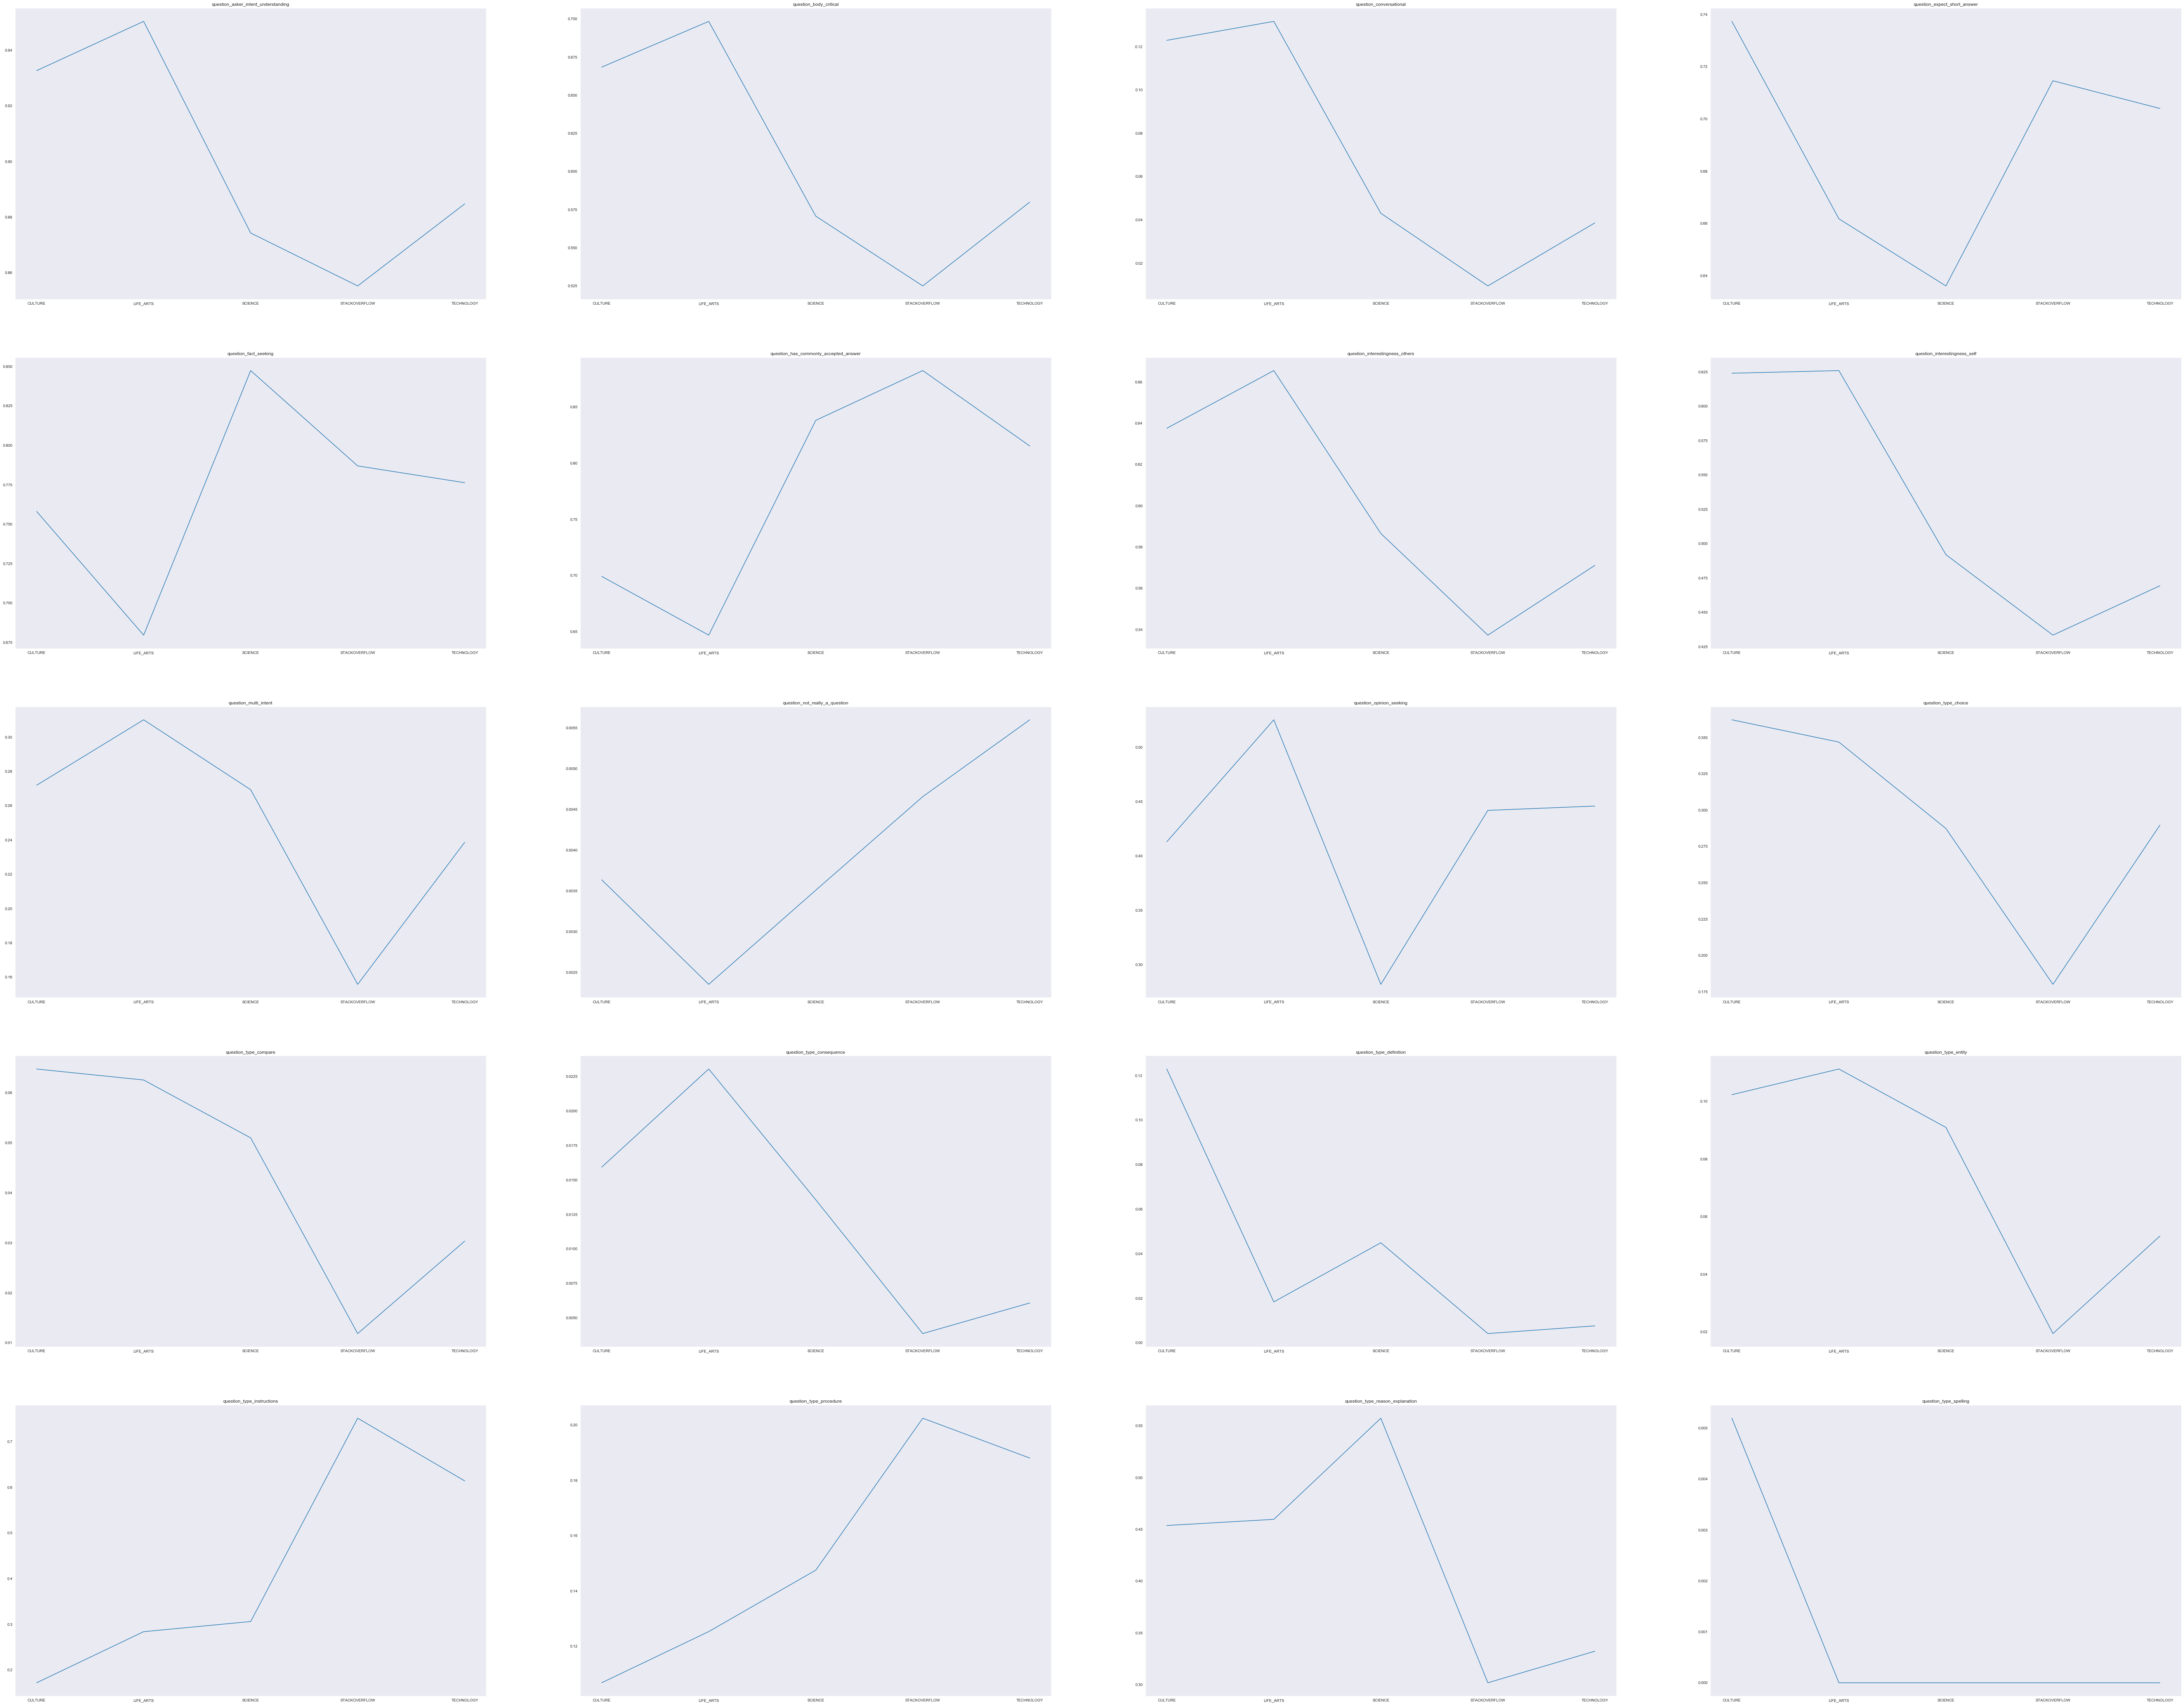

In [48]:
# Lets see how the mean value of one target feature for questions changes based on category
fig, axes = plt.subplots(5, 4, figsize=(100,80))
for idx in range(20):
    df = train.groupby('category')[question_target_cols[idx]].mean()
    axes[int(idx/4), idx%4].set_title(question_target_cols[idx])
    axes[int(idx/4), idx%4].plot(df, label=question_target_cols[idx])
plt.show()

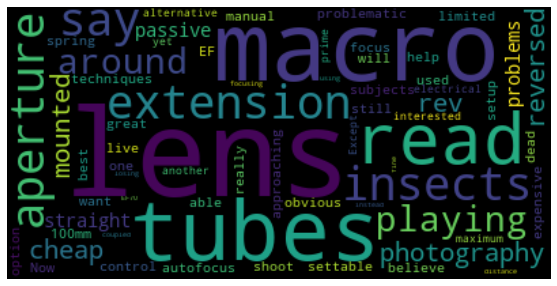

In [49]:
## Lets see the words of first question

plt.figure(figsize=(20, 5))

text = train.question_body[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

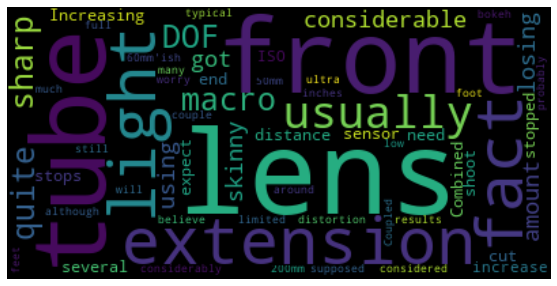

In [50]:
### Lets see the words of first answer
plt.figure(figsize=(20, 5))

text = train.answer[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
##How many words are there in all questions ? 

text = " ".join(question_body for question_body in train.question_body)
print ("There are {} words in the combination of all questions.".format(len(text)))

There are 5074508 words in the combination of all questions.


In [56]:
len(STOPWORDS)

192

In [57]:
len(set(STOPWORDS))

192

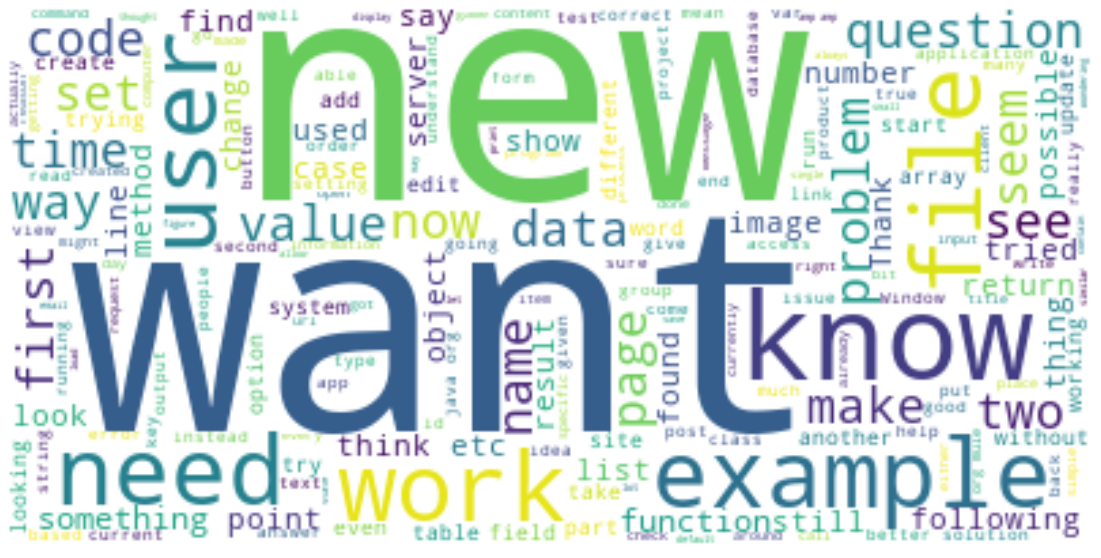

In [60]:
stopwords = set(STOPWORDS)
stopwords.update(["gt", "lt", "one", "use", "will","using"]) ## I found this list by first time running this cell without stopwords
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
len(wordcloud.words_)

200

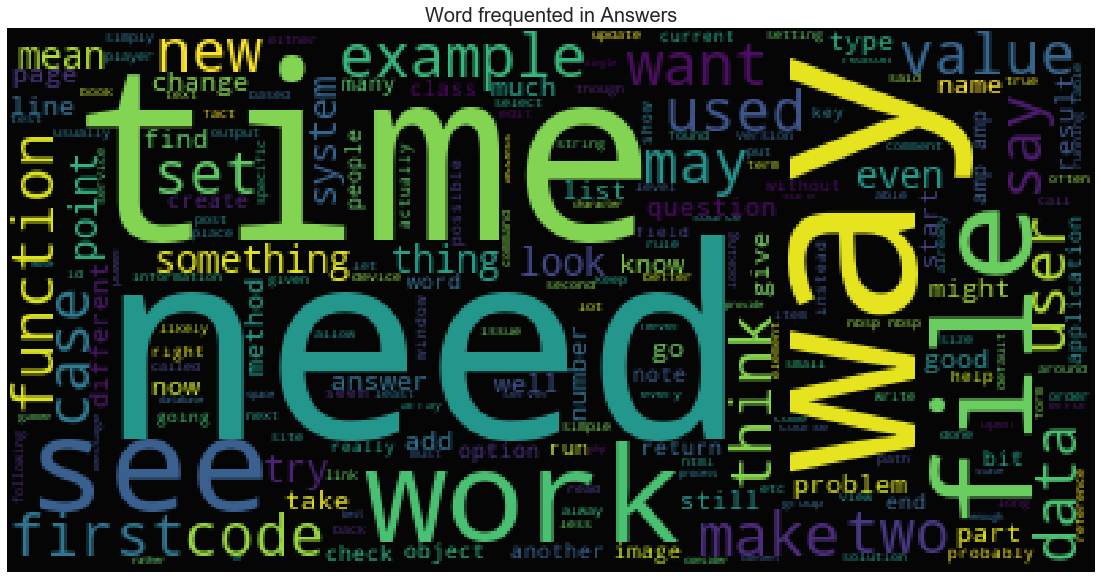

In [64]:
ans = ' '.join(answer for answer in train.answer)
wc = WordCloud(background_color='black', stopwords=stopwords).generate(ans)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.title('Word frequented in Answers', fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

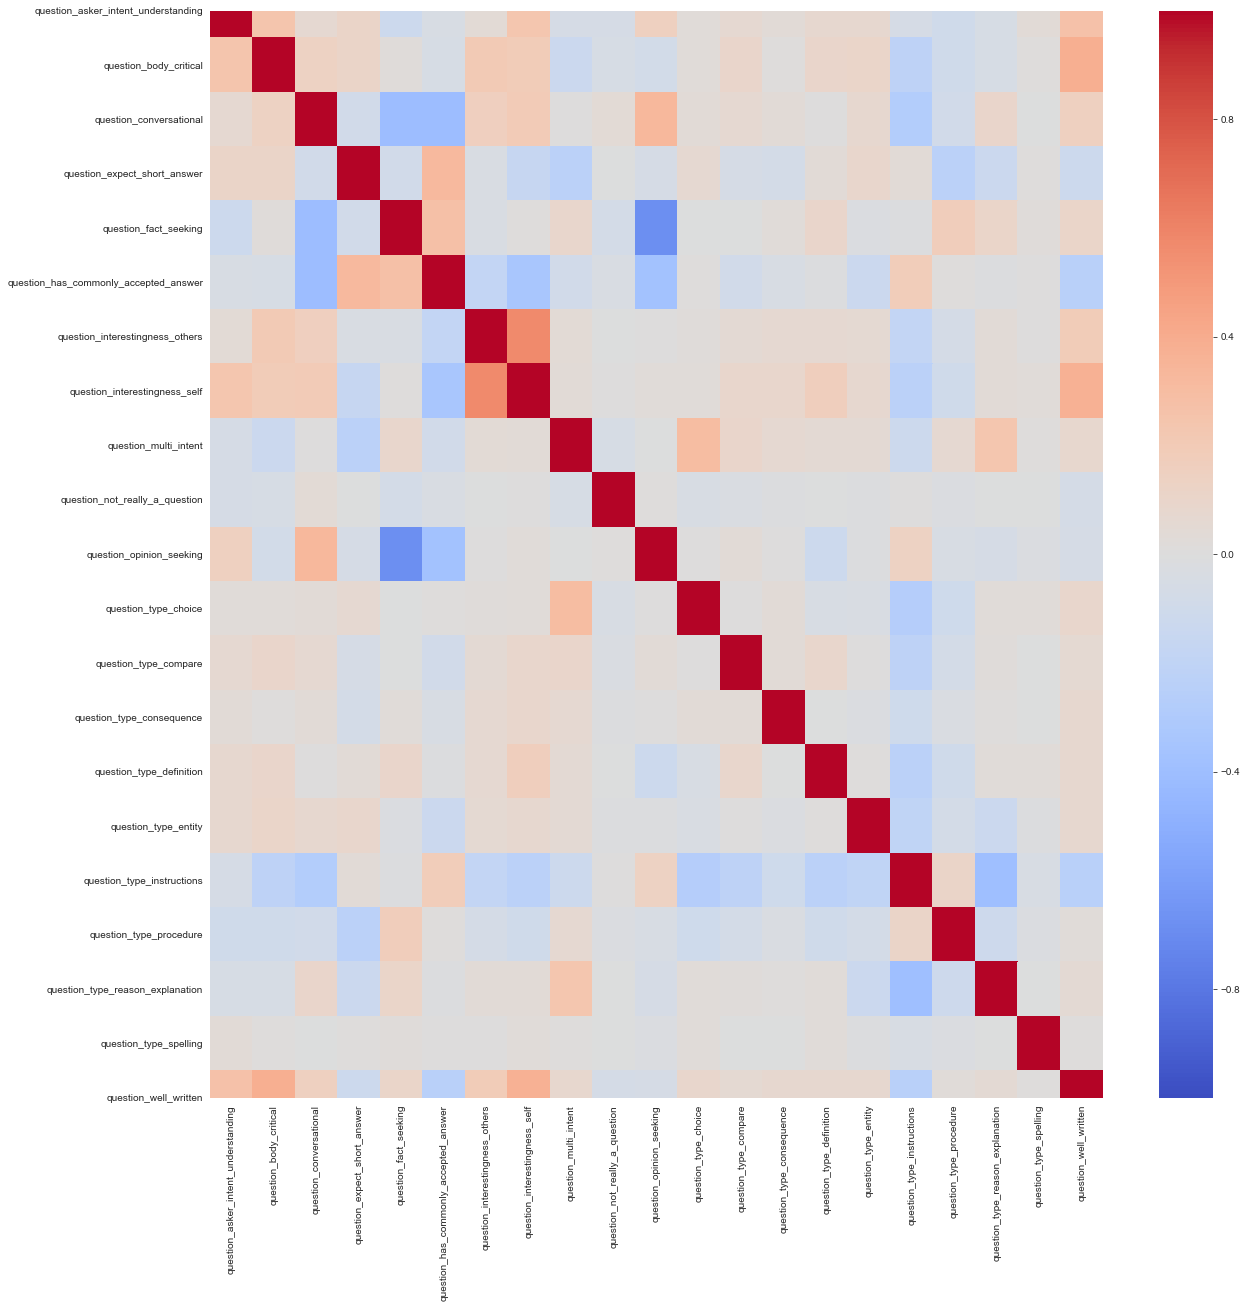

In [65]:
plt.figure(figsize=(20,20))
sns.heatmap(train[question_target_cols].corr(),vmin=-1,cmap='coolwarm')

### Inferences
- Question Interestingness self and others are very correlated.
- Its is also correlated that short answer seeking questions are commonly accepted.
- Question is well written and it is interesting to self are correlated
- Of Course the option seeking questions are more conversation.
- It is surprising to see that fact seeking and opinion seeking questions are strongly inversely correlated. Because I thought Fact+Bias=Opinion

In [66]:
train['category'].rank(method='dense', ascending=False).astype(int)

0       4
1       5
2       3
3       5
4       4
       ..
6074    5
6075    5
6076    1
6077    3
6078    4
Name: category, Length: 6079, dtype: int32

In [67]:
train['cat_label'] = train['category'].rank(method='dense', ascending=False).astype(int)

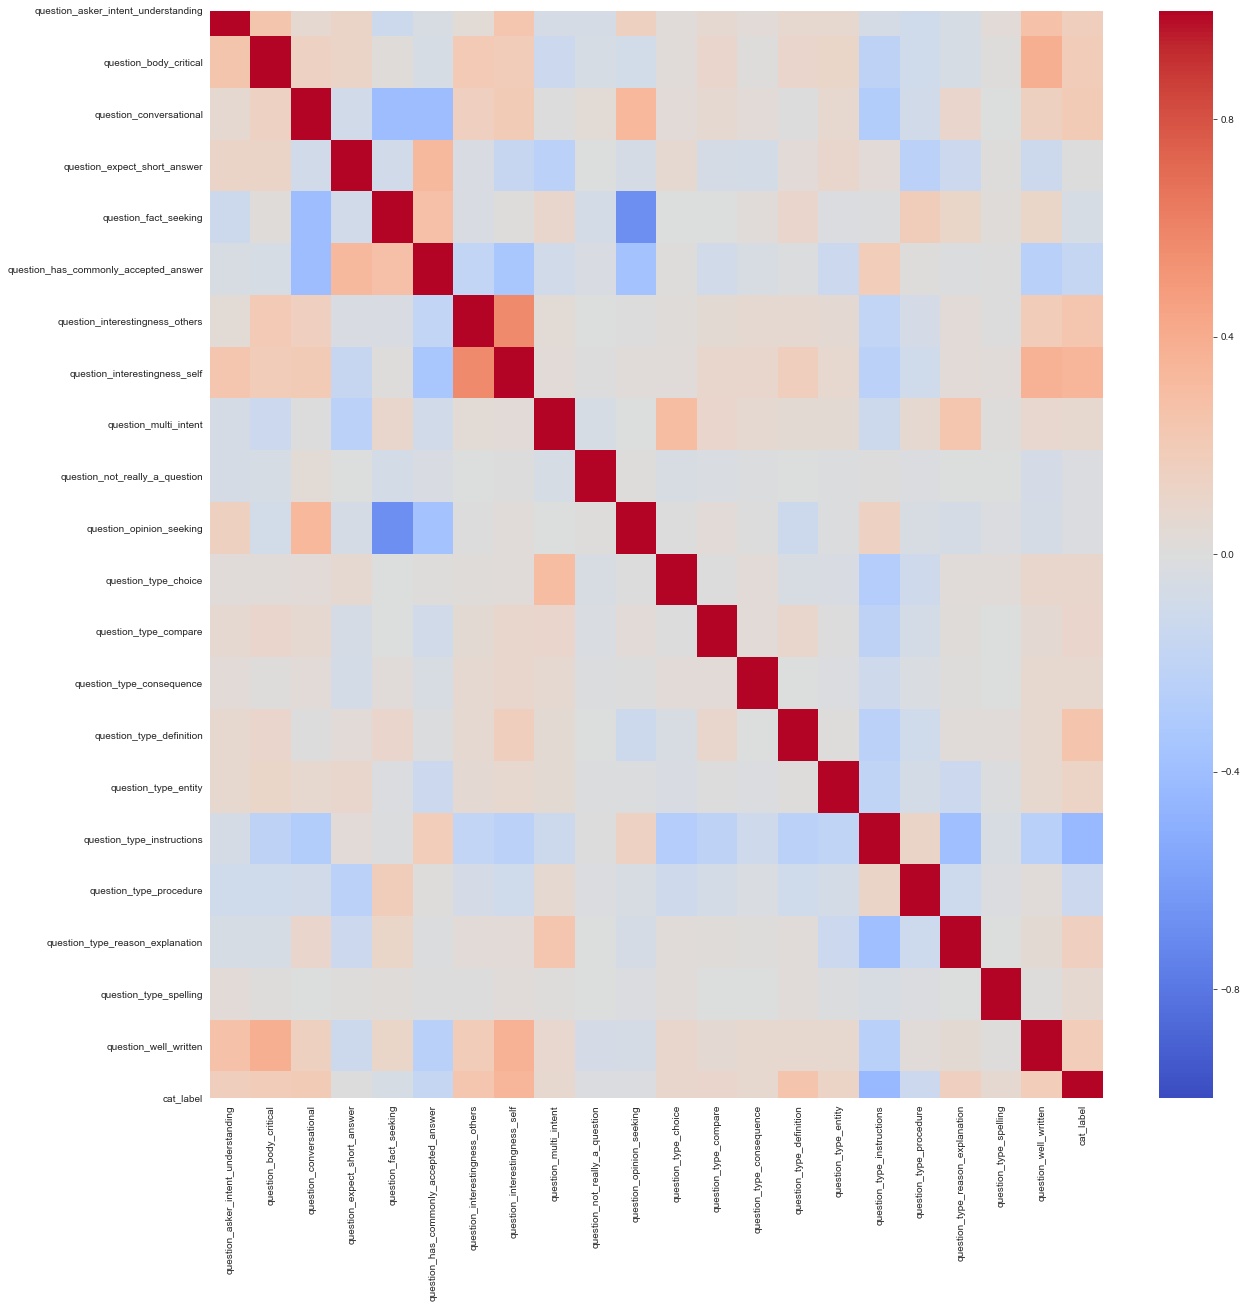

In [68]:
## lets see if its correlated to any category 
question_target_cols.append('cat_label')

plt.figure(figsize=(20,20))
sns.heatmap(train[question_target_cols].corr(),vmin=-1,cmap='coolwarm')

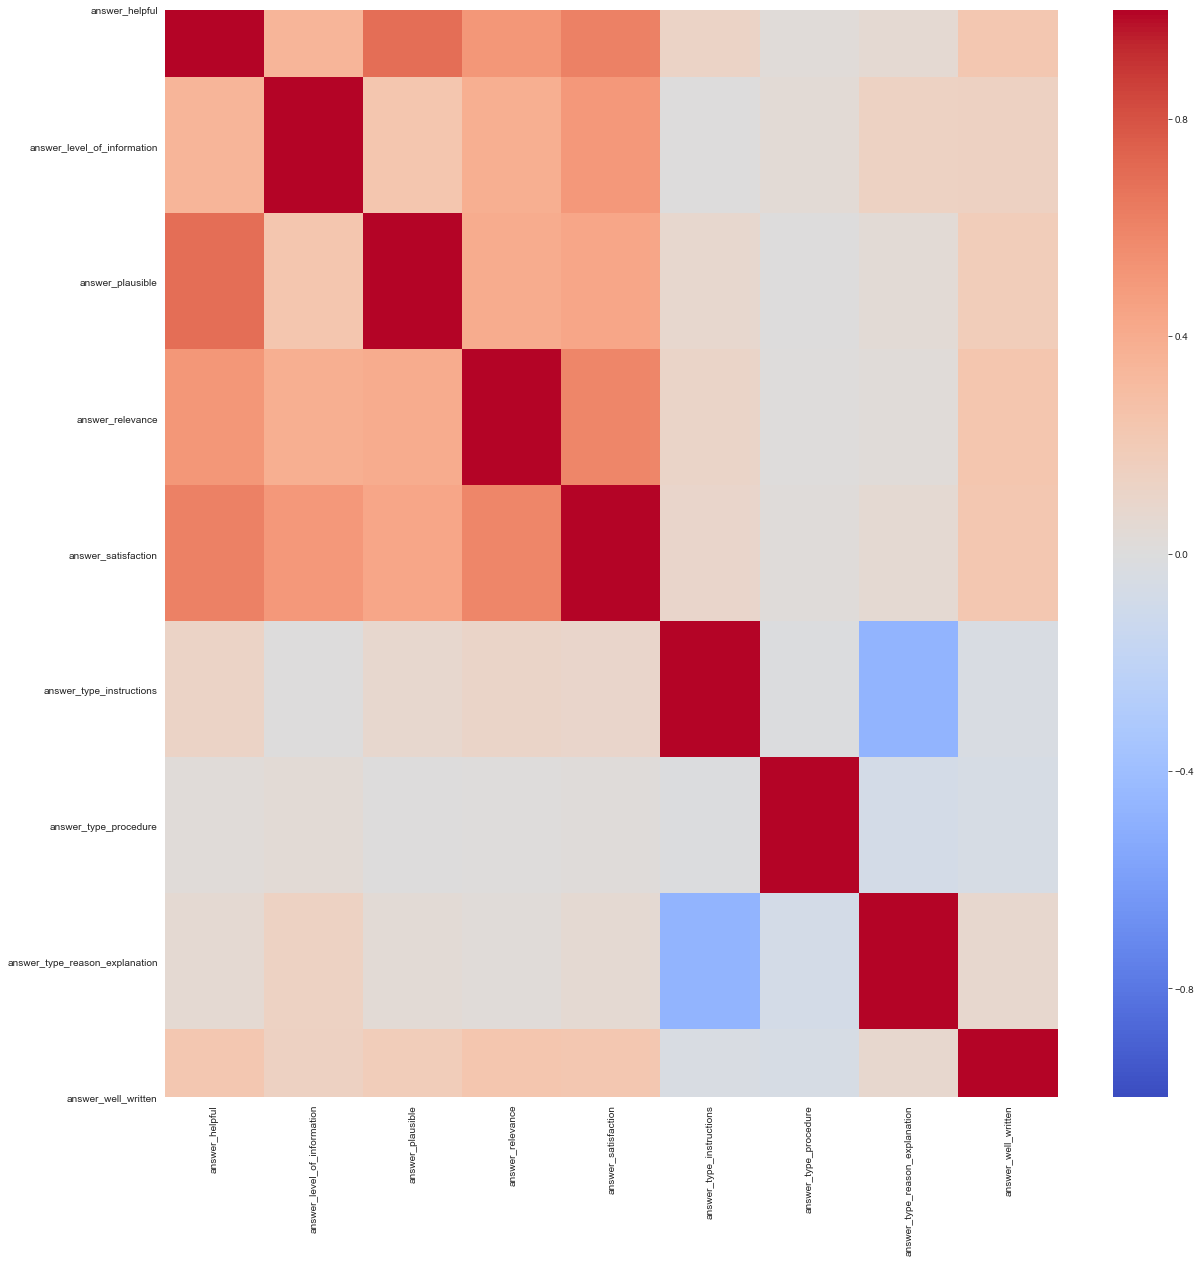

In [69]:
##Lets do the same for answers 
plt.figure(figsize=(20,20))
sns.heatmap(train[answer_target_cols].corr(),vmin=-1,cmap='coolwarm')

In [70]:
target_cols = question_target_cols + answer_target_cols
train['cat_host'] = train['category'] + train['host']

In [71]:
category_means_map = train.groupby(['cat_host'])[target_cols].mean().T.to_dict()

In [79]:
train.groupby(['cat_host'])[target_cols].mean()

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,cat_label,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
cat_host,,,,,,,,,,,,,,,,,,,,,
CULTUREanime.stackexchange.com,0.928571,0.746032,0.214286,0.698413,0.761905,0.817460,0.650794,0.515873,0.317460,0.000000,...,5,0.939153,0.671958,0.976190,0.986772,0.903175,0.015873,0.031746,0.714286,0.880952
CULTUREbicycles.stackexchange.com,0.930370,0.582963,0.051111,0.708889,0.833333,0.731111,0.642963,0.568889,0.333333,0.000000,...,5,0.918519,0.629630,0.960741,0.949630,0.841778,0.297778,0.084444,0.564444,0.907407
CULTUREboardgames.stackexchange.com,0.932007,0.686567,0.228856,0.743781,0.562189,0.574627,0.632670,0.532338,0.176617,0.000000,...,5,0.950249,0.669983,0.978441,0.983416,0.899502,0.141791,0.124378,0.614428,0.941957
CULTUREchristianity.stackexchange.com,0.942460,0.675595,0.342262,0.458333,0.553571,0.485119,0.645833,0.669643,0.297619,0.023810,...,5,0.910714,0.681548,0.938492,0.970238,0.850000,0.029762,0.035714,0.845238,0.922619
CULTUREell.stackexchange.com,0.933333,0.649673,0.084314,0.800000,0.794118,0.752941,0.631373,0.722876,0.186275,0.000000,...,5,0.910458,0.685621,0.959477,0.972549,0.863137,0.060784,0.070588,0.700000,0.913725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TECHNOLOGYunix.stackexchange.com,0.872942,0.605967,0.003086,0.672840,0.854938,0.831790,0.550926,0.445988,0.189815,0.000000,...,1,0.915638,0.655864,0.953704,0.959362,0.839815,0.753086,0.152778,0.412037,0.893004
TECHNOLOGYux.stackexchange.com,0.902635,0.626002,0.189003,0.627148,0.580756,0.484536,0.601947,0.537801,0.376289,0.003436,...,1,0.906644,0.678694,0.954181,0.956472,0.829553,0.286942,0.089347,0.606529,0.907216
TECHNOLOGYwebapps.stackexchange.com,0.950000,0.766667,0.008333,0.708333,0.841667,0.879167,0.669444,0.602778,0.141667,0.008333,...,1,0.936111,0.644444,0.968056,0.976389,0.860833,0.716667,0.133333,0.225000,0.913889


In [78]:
train.groupby(['cat_host'])[target_cols].mean().to_dict()

{'question_asker_intent_understanding': {'CULTUREanime.stackexchange.com': 0.9285714285714286,
  'CULTUREbicycles.stackexchange.com': 0.9303703703703701,
  'CULTUREboardgames.stackexchange.com': 0.9320066334991707,
  'CULTUREchristianity.stackexchange.com': 0.9424603174603171,
  'CULTUREell.stackexchange.com': 0.9333333333333328,
  'CULTUREenglish.stackexchange.com': 0.9640950994662778,
  'CULTUREgaming.stackexchange.com': 0.9239239239239235,
  'CULTUREjudaism.stackexchange.com': 0.881944444444444,
  'CULTUREmechanics.stackexchange.com': 0.9298245614035084,
  'CULTUREmeta.christianity.stackexchange.com': 0.8888888888888888,
  'CULTURErpg.stackexchange.com': 0.8970189701897009,
  'CULTUREtravel.stackexchange.com': 0.9530516431924881,
  'LIFE_ARTSacademia.stackexchange.com': 0.9460625674217904,
  'LIFE_ARTScooking.stackexchange.com': 0.9784411276948588,
  'LIFE_ARTSdiy.stackexchange.com': 0.9656357388316147,
  'LIFE_ARTSgraphicdesign.stackexchange.com': 0.9195906432748534,
  'LIFE_ARTSmo

In [76]:
len(category_means_map)

65

In [73]:
preds = train["cat_host"].map(category_means_map).apply(pd.Series)

In [74]:
preds

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,cat_label,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.947168,0.708061,0.137255,0.669935,0.673203,0.625817,0.642157,0.586601,0.307190,0.000000,...,4.0,0.950436,0.663943,0.978214,0.974946,0.872222,0.285948,0.143791,0.622549,0.917211
1,0.897019,0.632340,0.191057,0.600271,0.620596,0.589431,0.629630,0.552846,0.315718,0.002710,...,5.0,0.937669,0.692864,0.969286,0.980578,0.888076,0.227642,0.134146,0.644986,0.943993
2,0.872428,0.547325,0.004115,0.676955,0.800412,0.843621,0.572016,0.450617,0.269547,0.004115,...,3.0,0.921811,0.650892,0.974623,0.970508,0.856790,0.423868,0.176955,0.650206,0.941701
3,0.881944,0.605903,0.153646,0.604167,0.835938,0.716146,0.625868,0.603299,0.408854,0.005208,...,5.0,0.891493,0.641493,0.934028,0.957465,0.806250,0.052083,0.083333,0.781250,0.919271
4,0.919591,0.653509,0.048246,0.686404,0.758772,0.717105,0.622807,0.549708,0.302632,0.000000,...,4.0,0.944444,0.644737,0.982456,0.961257,0.842544,0.526316,0.100877,0.500000,0.932749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.930370,0.582963,0.051111,0.708889,0.833333,0.731111,0.642963,0.568889,0.333333,0.000000,...,5.0,0.918519,0.629630,0.960741,0.949630,0.841778,0.297778,0.084444,0.564444,0.907407
6075,0.930370,0.582963,0.051111,0.708889,0.833333,0.731111,0.642963,0.568889,0.333333,0.000000,...,5.0,0.918519,0.629630,0.960741,0.949630,0.841778,0.297778,0.084444,0.564444,0.907407
6076,0.872942,0.605967,0.003086,0.672840,0.854938,0.831790,0.550926,0.445988,0.189815,0.000000,...,1.0,0.915638,0.655864,0.953704,0.959362,0.839815,0.753086,0.152778,0.412037,0.893004
6077,0.837398,0.510840,0.069106,0.615854,0.813008,0.717480,0.566396,0.468157,0.337398,0.008130,...,3.0,0.892276,0.640921,0.934959,0.958672,0.809350,0.213415,0.107724,0.666667,0.918022


In [75]:
category_means_map.keys()

dict_keys(['CULTUREanime.stackexchange.com', 'CULTUREbicycles.stackexchange.com', 'CULTUREboardgames.stackexchange.com', 'CULTUREchristianity.stackexchange.com', 'CULTUREell.stackexchange.com', 'CULTUREenglish.stackexchange.com', 'CULTUREgaming.stackexchange.com', 'CULTUREjudaism.stackexchange.com', 'CULTUREmechanics.stackexchange.com', 'CULTUREmeta.christianity.stackexchange.com', 'CULTURErpg.stackexchange.com', 'CULTUREtravel.stackexchange.com', 'LIFE_ARTSacademia.stackexchange.com', 'LIFE_ARTScooking.stackexchange.com', 'LIFE_ARTSdiy.stackexchange.com', 'LIFE_ARTSgraphicdesign.stackexchange.com', 'LIFE_ARTSmoney.stackexchange.com', 'LIFE_ARTSmovies.stackexchange.com', 'LIFE_ARTSmusic.stackexchange.com', 'LIFE_ARTSphoto.stackexchange.com', 'LIFE_ARTSscifi.stackexchange.com', 'SCIENCEbiology.stackexchange.com', 'SCIENCEchemistry.stackexchange.com', 'SCIENCEcs.stackexchange.com', 'SCIENCEelectronics.stackexchange.com', 'SCIENCEmath.stackexchange.com', 'SCIENCEmathoverflow.net', 'SCIENC

In [80]:
from scipy.stats import spearmanr
overall_score = 0
for col in target_cols:
    overall_score += spearmanr(preds[col], train[col]).correlation / len(target_cols)
    print(col, spearmanr(preds[col], train[col]).correlation)

question_asker_intent_understanding 0.30927212305370644
question_body_critical 0.34848463545192004
question_conversational 0.36225613345099045
question_expect_short_answer 0.19924713581463108
question_fact_seeking 0.23402362603601937
question_has_commonly_accepted_answer 0.3270647472500346
question_interestingness_others 0.35865338882656406
question_interestingness_self 0.487661610856663
question_multi_intent 0.23687996328539443
question_not_really_a_question 0.08674931206262017
question_opinion_seeking 0.28771690488749013
question_type_choice 0.2523967744393584
question_type_compare 0.21108026157259407
question_type_consequence 0.14593132381029747
question_type_definition 0.31426570161463124
question_type_entity 0.24858633694975918
question_type_instructions 0.595091290867614
question_type_procedure 0.21292310957231805
question_type_reason_explanation 0.3246562485652123
question_type_spelling 0.1832668832258104
question_well_written 0.3481170025229528
cat_label 1.0
answer_helpful 0.12

In [81]:
overall_score

0.29104370791535705

In [82]:
target_cols = question_target_cols + answer_target_cols
test['cat_host'] = test['category'] + test['host']

In [87]:
len(test['cat_host'].value_counts())

56

In [94]:
set(test['cat_host'].values) - set(train['cat_host'].values)

{'TECHNOLOGYmeta.superuser.com'}

In [83]:
test_preds = test['cat_host'].map(category_means_map).apply(pd.Series)

In [84]:
test_preds

,0,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,NaN,0.937938,0.654154,0.958458,0.973473,0.873273,0.319820,0.117117,0.573574,0.888388,...,0.312312,0.057057,0.022523,0.021021,0.108108,0.396396,0.130631,0.394895,0.0,0.871371
1,NaN,0.951989,0.648148,0.973251,0.970508,0.867078,0.794239,0.191358,0.327160,0.891632,...,0.179012,0.008230,0.000000,0.000000,0.026749,0.792181,0.234568,0.306584,0.0,0.739369
2,NaN,0.937938,0.654154,0.958458,0.973473,0.873273,0.319820,0.117117,0.573574,0.888388,...,0.312312,0.057057,0.022523,0.021021,0.108108,0.396396,0.130631,0.394895,0.0,0.871371
3,NaN,0.950450,0.666667,0.975976,0.978979,0.890090,0.644144,0.216216,0.418919,0.888889,...,0.504505,0.036036,0.000000,0.009009,0.009009,0.590090,0.207207,0.382883,0.0,0.833333
4,NaN,0.934272,0.666667,0.962441,0.957746,0.844131,0.267606,0.145540,0.591549,0.926448,...,0.455399,0.028169,0.014085,0.009390,0.197183,0.314554,0.178404,0.333333,0.0,0.863850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,NaN,0.945238,0.665873,0.964683,0.981746,0.901429,0.804762,0.172619,0.254762,0.911905,...,0.205952,0.014286,0.002381,0.000000,0.038095,0.779762,0.240476,0.177381,0.0,0.761905
472,NaN,0.927153,0.637581,0.957391,0.972111,0.853684,0.729715,0.152301,0.350359,0.894032,...,0.180101,0.011838,0.003857,0.004123,0.019420,0.751264,0.202447,0.301676,0.0,0.733573
473,NaN,0.953566,0.665837,0.968491,0.978441,0.863682,0.746269,0.154229,0.420398,0.897181,...,0.228856,0.029851,0.019900,0.000000,0.029851,0.721393,0.253731,0.328358,0.0,0.707297
474,NaN,0.950249,0.669983,0.978441,0.983416,0.899502,0.141791,0.124378,0.614428,0.941957,...,0.480100,0.009950,0.032338,0.000000,0.124378,0.149254,0.161692,0.390547,0.0,0.886401


In [99]:
test_preds.drop(0, axis=1, inplace=True)

In [100]:
test_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 31 columns):
answer_helpful                           474 non-null float64
answer_level_of_information              474 non-null float64
answer_plausible                         474 non-null float64
answer_relevance                         474 non-null float64
answer_satisfaction                      474 non-null float64
answer_type_instructions                 474 non-null float64
answer_type_procedure                    474 non-null float64
answer_type_reason_explanation           474 non-null float64
answer_well_written                      474 non-null float64
cat_label                                474 non-null float64
question_asker_intent_understanding      474 non-null float64
question_body_critical                   474 non-null float64
question_conversational                  474 non-null float64
question_expect_short_answer             474 non-null float64
question_fact_seeking      

In [111]:
np.where(np.isnan(test_preds))

(array([273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273,
        273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273,
        273, 273, 273, 273, 273, 364, 364, 364, 364, 364, 364, 364, 364,
        364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364,
        364, 364, 364, 364, 364, 364, 364, 364, 364, 364], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64))

In [112]:
for col in target_cols:
    sub[col] = test_preds[col]

In [113]:
sub.fillna(value=0.00000, inplace=True)

In [114]:
sub.to_csv('submission-v1.csv', index=False)

In [115]:
sub.loc[sub['question_asker_intent_understanding'].isna() == True]

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,cat_label


## More EDA

In [116]:
train.iloc[:,1:3]

,question_title,question_body
0,What am I losing when using extension tubes in...,After playing around with macro photography on...
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic..."
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...
...,...,...
6074,Using a ski helmet for winter biking,I am curious if anyone uses a skiing helmet fo...
6075,Adjustment to road bike brakes for high grade ...,I have a road bike with a front brake that wea...
6076,Suppress 'file truncated' messages when using ...,I'm tailing a log file using tail -f messages....
6077,When should a supervisor be a co-author?,What are people's views on this? To be specif...


In [117]:
merge = pd.concat([train.iloc[:,0:3], test.iloc[:,0:3]])

In [118]:
merge

,qa_id,question_title,question_body
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic..."
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...
...,...,...,...
471,9569,change gb4e enumeration in only one chapter,I am using gb4e for glossing examples in my th...
472,9590,All anagrams in a File,Source : Microsoft Interview Question\n\nWe ar...
473,9597,SQL Server: Time Series Table Design,I am creating a time series database that foll...
474,9623,Is a countered flashback spell exiled?,If I flashback Past in Flames and it is counte...


In [119]:
df_q=merge.reset_index(drop=True)

In [120]:
df_q

,qa_id,question_title,question_body
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic..."
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...
...,...,...,...
6550,9569,change gb4e enumeration in only one chapter,I am using gb4e for glossing examples in my th...
6551,9590,All anagrams in a File,Source : Microsoft Interview Question\n\nWe ar...
6552,9597,SQL Server: Time Series Table Design,I am creating a time series database that foll...
6553,9623,Is a countered flashback spell exiled?,If I flashback Past in Flames and it is counte...


In [123]:
## Indirect features
df_q['count_sent'] = df_q['question_body'].apply(lambda x: len(re.findall('\n', str(x))) + 1) # 句子数量
df_q['count_word'] = df_q['question_body'].apply(lambda x: len(str(x).split()))  # 单词数量
df_q['count_unique_word'] = df_q['question_body'].apply(lambda x: len(set(str(x).split()))) # 词典大小
#Letter count
df_q['count_letters']=df_q["question_body"].apply(lambda x: len(str(x)))
#punctuation count
df_q["count_punctuations"] =df_q["question_body"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df_q["count_words_upper"] = df_q["question_body"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df_q["count_words_title"] = df_q["question_body"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df_q["count_stopwords"] = df_q["question_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df_q["mean_word_len"] = df_q["question_body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [124]:
#derived features
#Word count percent in each comment:
df_q['word_unique_percent']=df_q['count_unique_word']*100/df_q['count_word']
#derived features
#Punct percent in each comment:
df_q['punct_percent']=df_q['count_punctuations']*100/df_q['count_word']

In [129]:
df_q

,qa_id,question_title,question_body,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,6,141,107,836,34,8,15,53,4.914894,75.886525,24.113475
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,4,142,102,789,30,3,12,60,4.528169,71.830986,21.126761
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,4,118,79,653,20,6,8,53,4.525424,66.949153,16.949153
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",6,75,52,425,11,0,6,36,4.640000,69.333333,14.666667
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,6,81,52,416,14,6,10,40,4.098765,64.197531,17.283951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,9569,change gb4e enumeration in only one chapter,I am using gb4e for glossing examples in my th...,2,58,47,307,6,3,4,28,4.293103,81.034483,10.344828
6551,9590,All anagrams in a File,Source : Microsoft Interview Question\n\nWe ar...,9,42,38,245,6,0,11,17,4.738095,90.476190,14.285714
6552,9597,SQL Server: Time Series Table Design,I am creating a time series database that foll...,6,183,110,1074,26,8,14,85,4.846995,60.109290,14.207650
6553,9623,Is a countered flashback spell exiled?,If I flashback Past in Flames and it is counte...,2,21,19,105,2,1,5,12,4.000000,90.476190,9.523810


In [125]:
train.iloc[:,2:]

,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,...,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,cat_label,cat_host
0,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,...,0.666667,1.000000,1.000000,0.800000,1.000000,0.000000,0.000000,1.000000,4,LIFE_ARTSphoto.stackexchange.com
1,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,...,0.555556,0.888889,0.888889,0.666667,0.000000,0.000000,0.666667,0.888889,5,CULTURErpg.stackexchange.com
2,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,...,0.555556,1.000000,1.000000,0.666667,0.000000,0.333333,1.000000,0.888889,3,SCIENCEelectronics.stackexchange.com
3,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,...,0.333333,0.833333,1.000000,0.800000,0.000000,0.000000,1.000000,1.000000,5,CULTUREjudaism.stackexchange.com
4,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,...,0.666667,1.000000,1.000000,0.800000,1.000000,0.000000,1.000000,1.000000,4,LIFE_ARTSgraphicdesign.stackexchange.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,I am curious if anyone uses a skiing helmet fo...,sixtyfootersdude,https://bicycles.stackexchange.com/users/134,If you're thinking about wearing a ski helmet ...,Matt Leo,https://bicycles.stackexchange.com/users/3340,http://bicycles.stackexchange.com/questions/99...,CULTURE,bicycles.stackexchange.com,1.000000,...,0.555556,1.000000,1.000000,0.866667,0.000000,0.000000,0.000000,0.888889,5,CULTUREbicycles.stackexchange.com
6075,I have a road bike with a front brake that wea...,ash,https://bicycles.stackexchange.com/users/14519,\nYou can replace the pads (as stated elsewher...,Daniel R Hicks,https://bicycles.stackexchange.com/users/1584,http://bicycles.stackexchange.com/questions/25...,CULTURE,bicycles.stackexchange.com,1.000000,...,0.555556,1.000000,1.000000,0.733333,0.666667,0.333333,0.000000,0.888889,5,CULTUREbicycles.stackexchange.com
6076,I'm tailing a log file using tail -f messages....,Maneating Koala,https://unix.stackexchange.com/users/60445,Maybe help if can be fixes origin of this erro...,BG Bruno,https://unix.stackexchange.com/users/68208,http://unix.stackexchange.com/questions/169054...,TECHNOLOGY,unix.stackexchange.com,0.888889,...,0.555556,0.888889,0.888889,0.800000,1.000000,0.000000,0.333333,0.555556,1,TECHNOLOGYunix.stackexchange.com
6077,What are people's views on this? To be specif...,MrB,https://mathoverflow.net/users/2189,"As a non-mathematician, I am somewhat mystifie...",angela,https://mathoverflow.net/users/4267

In [126]:
#serperate train and test features
train_feats=df_q.iloc[0:len(train),]
test_feats=df_q.iloc[len(train):,]
len(train)

6079

In [127]:
train[question_target_cols]

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,cat_label
0,1.000000,0.333333,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000,4
1,1.000000,1.000000,0.000000,0.500000,1.000000,1.0,0.444444,0.444444,0.666667,0.0,...,0.666667,0.0,0.333333,0.0,0.000000,0.000000,0.333333,0.0,0.888889,5
2,0.888889,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.444444,0.333333,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.333333,0.333333,0.0,0.777778,3
3,0.888889,0.666667,0.666667,1.000000,1.000000,1.0,0.444444,0.444444,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.888889,5
4,1.000000,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.666667,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,1.000000,0.777778,0.000000,1.000000,1.000000,1.0,0.888889,0.888889,0.333333,0.0,...,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.0,0.777778,5
6075,1.000000,0.777778,0.000000,1.000000,0.666667,0.5,0.777778,0.777778,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.666667,0.666667,0.000000,0.0,0.777778,5
6076,0.888889,0.555556,0.000000,0.666667,0.333333,1.0,0.444444,0.333333,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.444444,1
6077,1.000000,0.444444,0.333333,0.000000,0.000000,0.0,0.777778,0.555556,1.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.666667,0.0,1.000000,3


In [128]:
question_target_cols.append('qa_id')